# Recuperação da Informação e Busca na Web - 2018.1

### Atividade: Projeto Final - Agrupamento de Notícias
### Aluno: Johanny de Lucena Santos

## - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

## Descrição do projeto
O projeto escolhido para ser realizado foi o **agrupamento de notícias**. Usei como base de estudos, um conjunto de notícias do portal Estadão, com o tema **"Eleição"**. Essa base de dados possui um conjunto de pouco mais de 8700 notícias, relativas ao período de 03/01/2014 à 31/12/2014. A ideia básica do projeto é agrupar os dados em grupos semelhantes entre si de modo a poder tirar alguma informação relevante disso.

## Ferramenta utilizada
Para realizar esse agrupamento, irei utilizar uma biblioteca de aprendizagem de máquina chamada **Scikit-Learn**, mais precisamente o algoritmo **K-Means**. 

O K-means é um algoritmo muito interessante para essa tarefa pois além de ser fácil, é extremamente eficiente e ainda por cima relativamente rápido para tarefa que se propõe.

A estratégia consiste em criar K centróides em localizações aleatórias, calcular as distância desses centróides em relação às instâncias mais próximas e classificá-las como pertencente ao cluster que tem como centro o centróide mais próximo. Feito isso movemos os centros para a localização média do espaço e refazemos o processo.

## Importação das bibliotecas necessárias
Aqui, iremos usar a biblioteca pandas, para tratar o DataFrame, nltk, para as stopwords, matplotlib, para plotagem dos gráficos juntamente com wordcloud, e por fim, a biblioteca sklearn (scikit-learn), responsável por gerar os grupos de palavras.

In [20]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords

import re
import random
from collections import Counter
from unicodedata import normalize
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import seaborn as sb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn import feature_extraction
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS #pip install wordcloud



In [2]:
#nltk.download('punkt')
#nltk.download('corpus')

### Funções úteis

In [2]:
#Função responsável por remover caracteres especiais e acentuações
def limpar_texto(texto):
    pattern = re.compile('[^a-zA-Z0-9 ]')
    texto = normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')
    return pattern.sub(' ', texto)

## Configurando stopwords

In [50]:
stopwords = nltk.corpus.stopwords.words('portuguese')
words = set([limpar_texto(stopword) for stopword in stopwords])

True

## Importando a base de dados necessária para o agrupamento de notícias

Aqui, é feita a importação do arquivo csv para a análise. Em seguida, substituo as linhas com NaN por um espaço em branco. E por fim, um array é criado, onde cada índice possui o título, subtítulo e conteúdo da notícia.

Obs: a fim de facilitar a execução dos algoritmos, decidi reduzir a quantidade de notícias a ser agrupadas (1089 notícias), pois a grande quantidade do banco de notícias afetou muito no desempenho, chegando algumas vezes a travar o sistema operacional.

In [57]:
file_path = '../data/estadao_noticias_eleicao.csv'

base = pd.read_csv(file_path, encoding = "utf-8")
size = int(len(pd.read_csv(file_path, encoding="utf-8")) / 20)
skip = random.sample(range(1, len(base)), len(base) - size)
base = pd.read_csv(file_path, skiprows=skip, encoding = "utf-8")
base = base.replace(np.nan, "", regex=True)

documentos = base.titulo + " " + base.subTitulo + " " + base.conteudo
documentos = documentos.fillna("")
documentos = documentos.apply(limpar_texto)
documentos = documentos.apply(lambda texto: limpar_texto(texto).lower())

#tokens = documentos.apply(nltk.word_tokenize)
#term_frequence = tokens.apply(Counter)

noticias = []

for doc in documentos:
    tokens = nltk.tokenize.word_tokenize(doc)
    filtro = [w for w in tokens if not w in words]
    noticia = ' '.join(filtro)
    noticias.append(noticia)


## Definindo número de clusters
Aqui, iremos calcular o número ideal de clusters para agrupar nossas notícias, baseado no número de colunas que nosso dataset possui.

In [58]:
labels  = base.columns
true_k = np.unique(labels).shape[0]

In [59]:
size

417

## Funções para auxiliar na geração dos gráficos
Aqui temos duas funções para auxiliar na geração da nuvem de palavras (wordcloud) de cada cluster, bem como uma função que gera um gráfico de barras

In [60]:
"""
    Função responsável por gerar o wordcloud de cada cluster
"""
def generate_wordcloud(text):
    wordcloud = WordCloud(background_color='black',
                      width=1600,
                      height= 800,
                      min_font_size=10,
                      font_path='./data/NotoSansDisplay-Regular.ttf',
                      relative_scaling = 1.0,
                      ).generate(clusters[group])
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
"""
    Função responsável por gerar as n palavras mais frequentes em cada cluster
"""
def top_word_frequency(termos, num_palavras):
    for group in sorted(termos.keys()):
        s = termos[group][:num_palavras]
        y = []
        x = []
        for i in range(len(s)):
            x.append(s[i][0])
            y.append(s[i][1])
            
        plt.figure(figsize=(10,7))
        plt.barh(x, y, color="black")
        plt.xlabel("Frequência")
        plt.title("Top 10 palavras frequentes do Cluster %d" % (group+1))

## Calculando TF-IDF
Através da biblioteca sklearn, calculamos o TF-IDF de cada palavra no documento que possui o conjunto de notícias

In [61]:
vectorizer = TfidfVectorizer(stop_words=words,analyzer='word',ngram_range=(1, 1), lowercase=True, use_idf=True)
X = vectorizer.fit_transform(documentos)

## Utilizando o Método Elbow
Aqui, é aplicado o método Elbow para calcular o melhor valor para definir o número de clusters do nosso conjunto de notícias. Iremos utilizar valores de 1 a 10 para calcular o número de clusters. 

Os valores para K estão no eixo horizontal. No eixo Y, está a distorção (os valores calculados com a função custo). 

Na medida que K vai aumentando, os centróides vão ficando mais próximos dos centróides dos clusters. Os pontos irão diminuir, em algum momento rapidamente, criando a forma de um cotovelo. Esse ponto onde começa a criar a forma é o valor ideal para K. No nosso caso, será o ponto K = 6.

In [62]:
distortions = []
for k in range(1,10):
    model = KMeans(n_clusters=k).fit(X)
    model.fit(X.toarray()) 
    distortions.append(sum(np.min(cdist(X.toarray(), 
                                        model.cluster_centers_, 
                                        'euclidean'), 
                                  axis=1)
                          ) / X.toarray().shape[0])

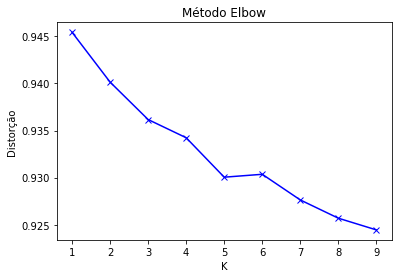

In [64]:
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distorção')
plt.title('Método Elbow')
plt.show()

Podemos ver através do gráfico plotado acima que o valor ideal para K é o ponto K = 6.

## Gerando o nosso modelo usando o algoritmo K-Means

In [65]:
model = KMeans(n_clusters=6, init='k-means++',max_iter=1000, n_init=1)
model.fit(X.toarray())

labels = model.labels_
centroids = np.array(model.cluster_centers_)

## Gerando o word cloud dos clusters

Para cada conjunto de palavras dos clusters, a que mais se repete é a que vai ter um tamanho de fonte maior


Cluster 1:


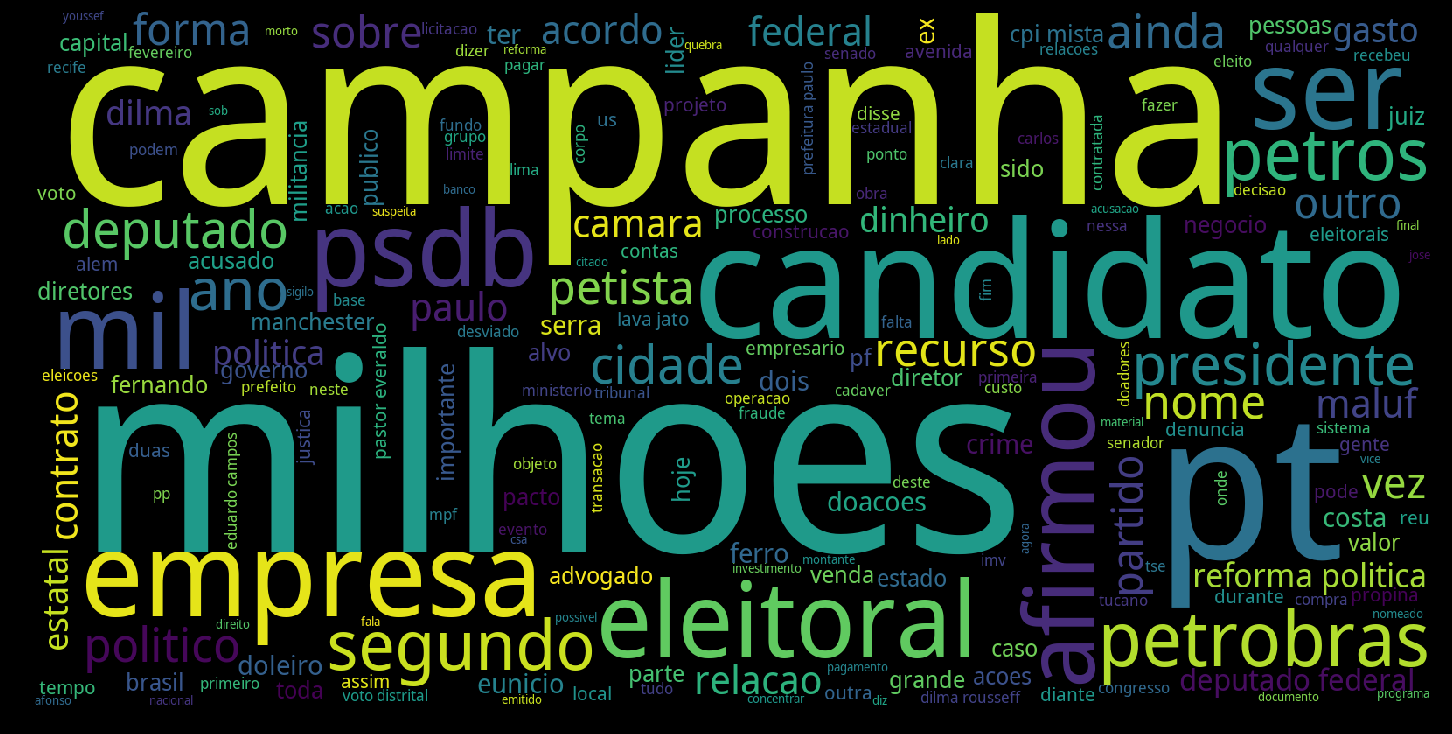


Cluster 2:


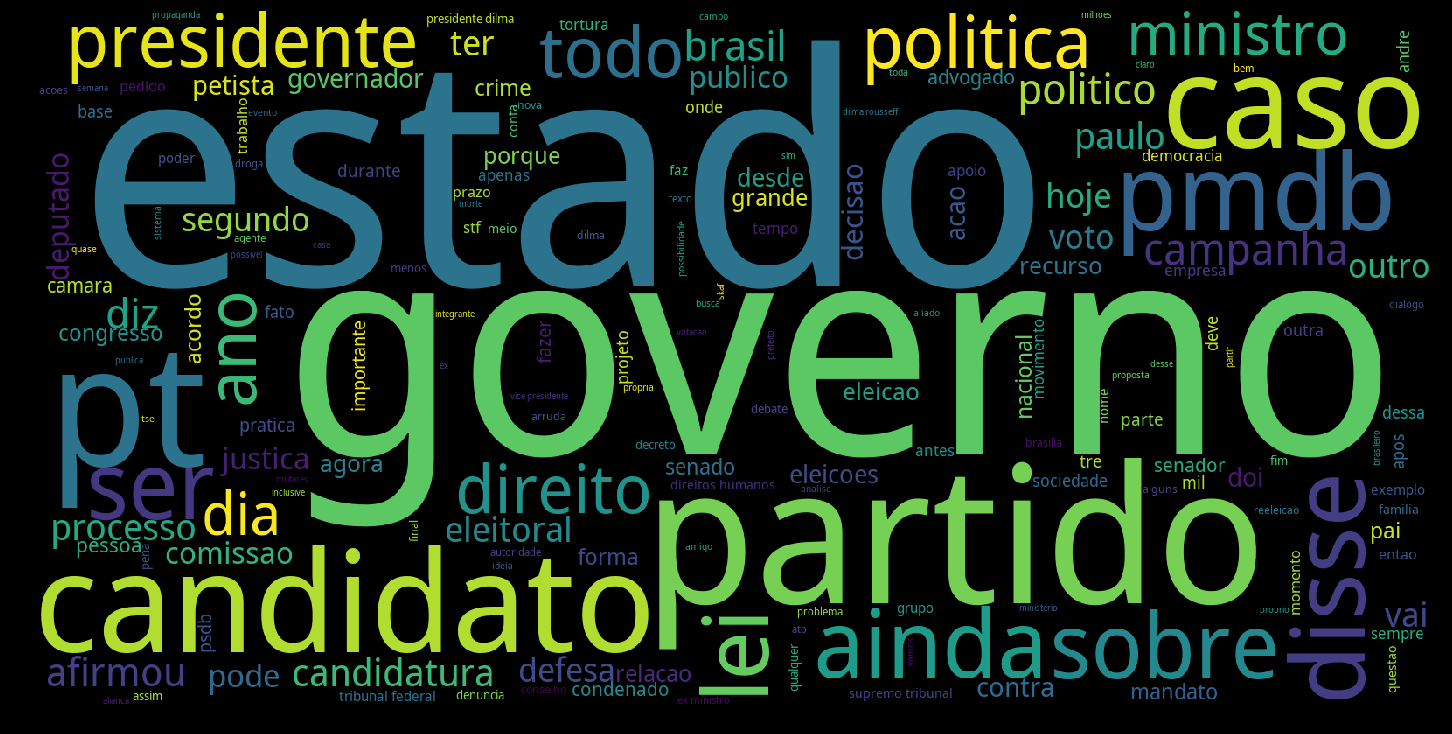


Cluster 3:


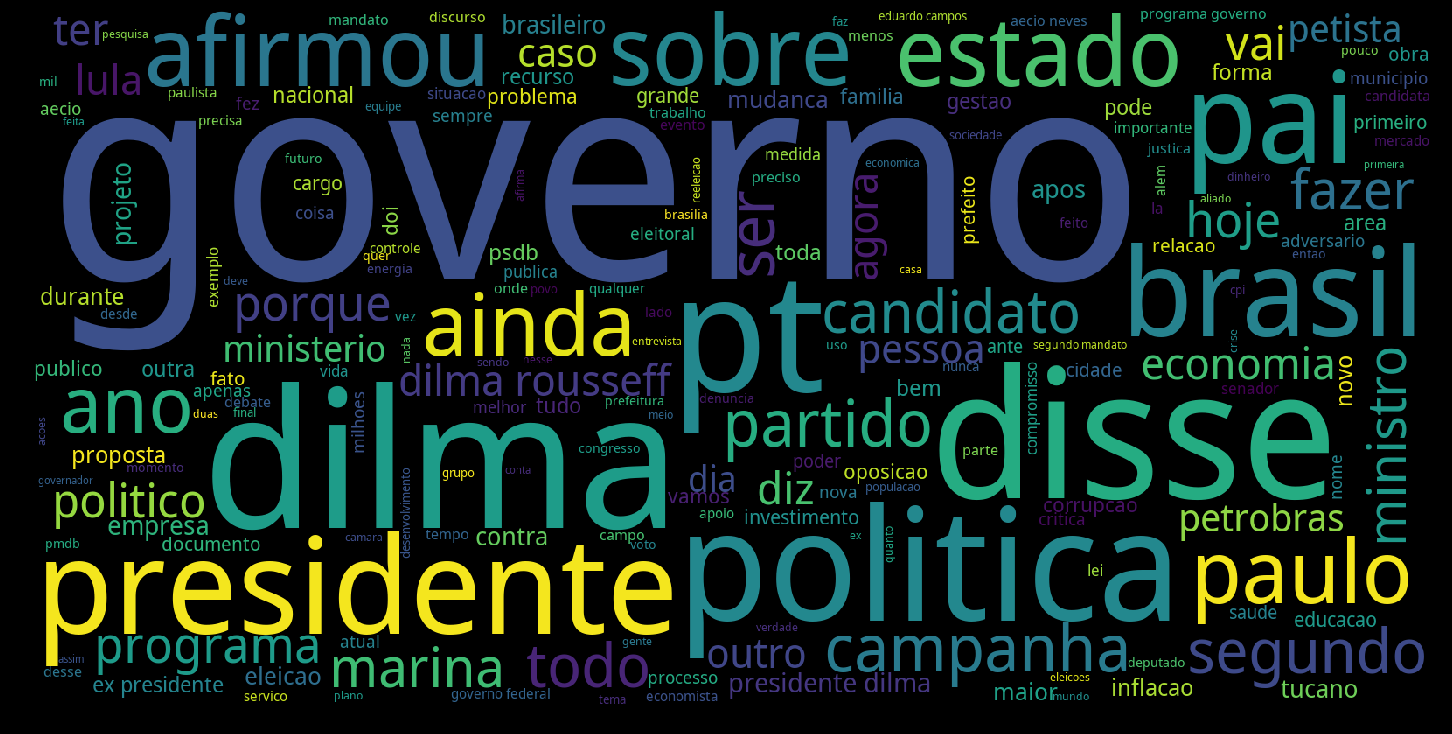


Cluster 4:


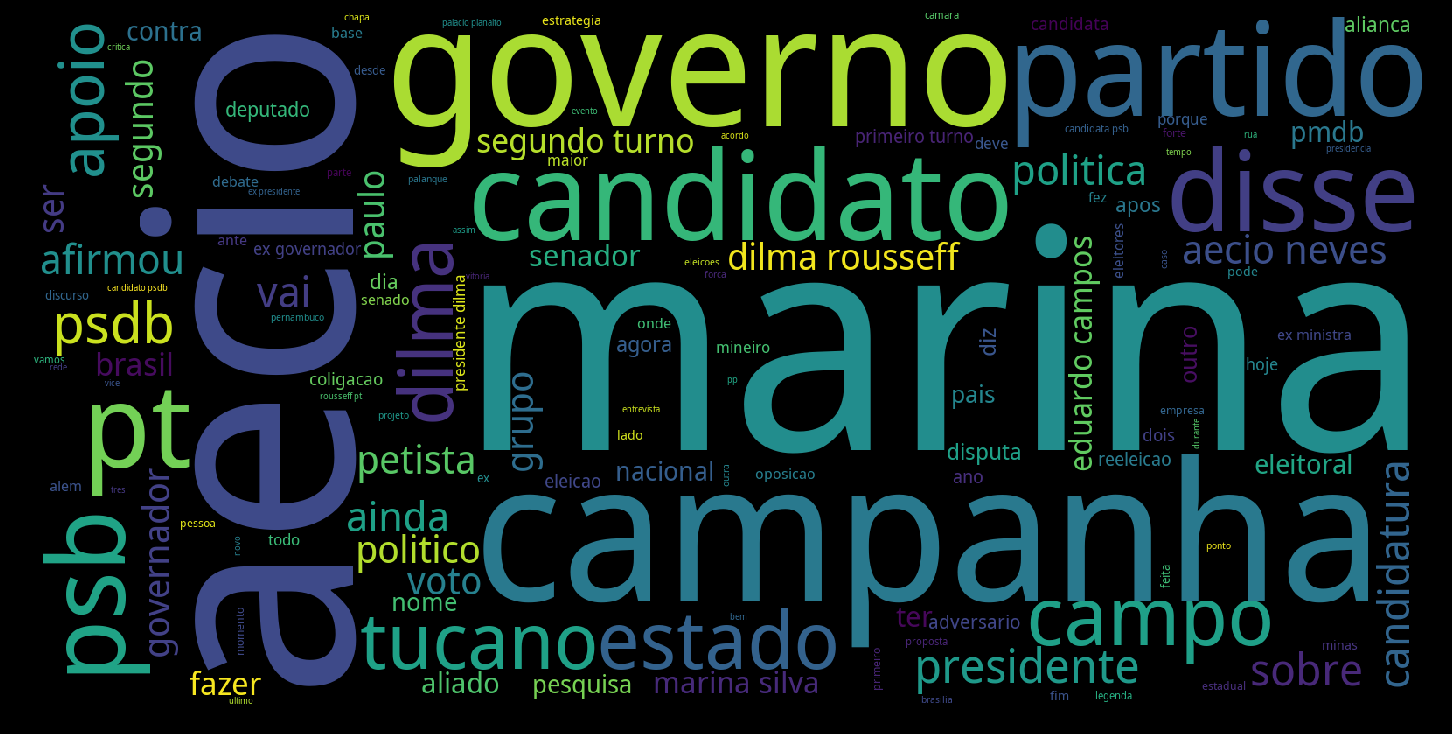


Cluster 5:


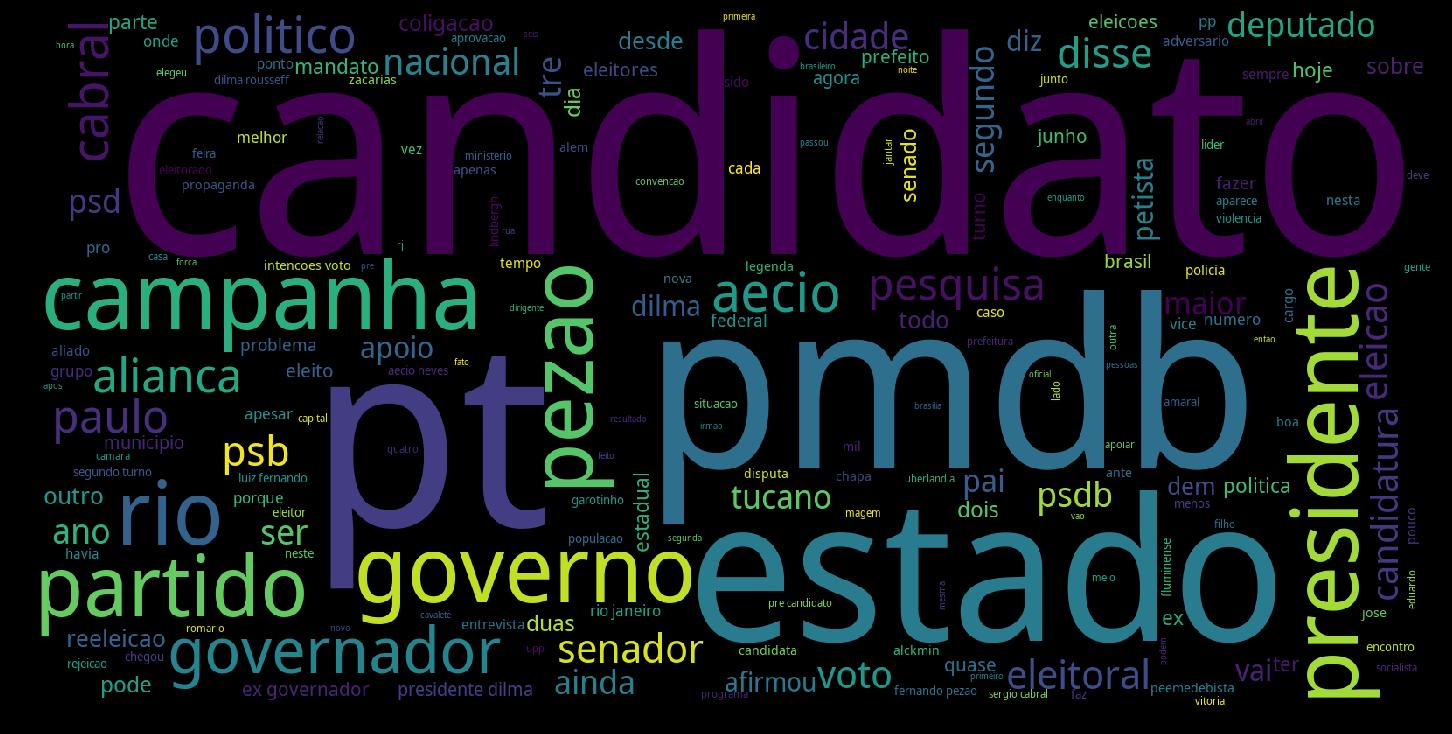


Cluster 6:


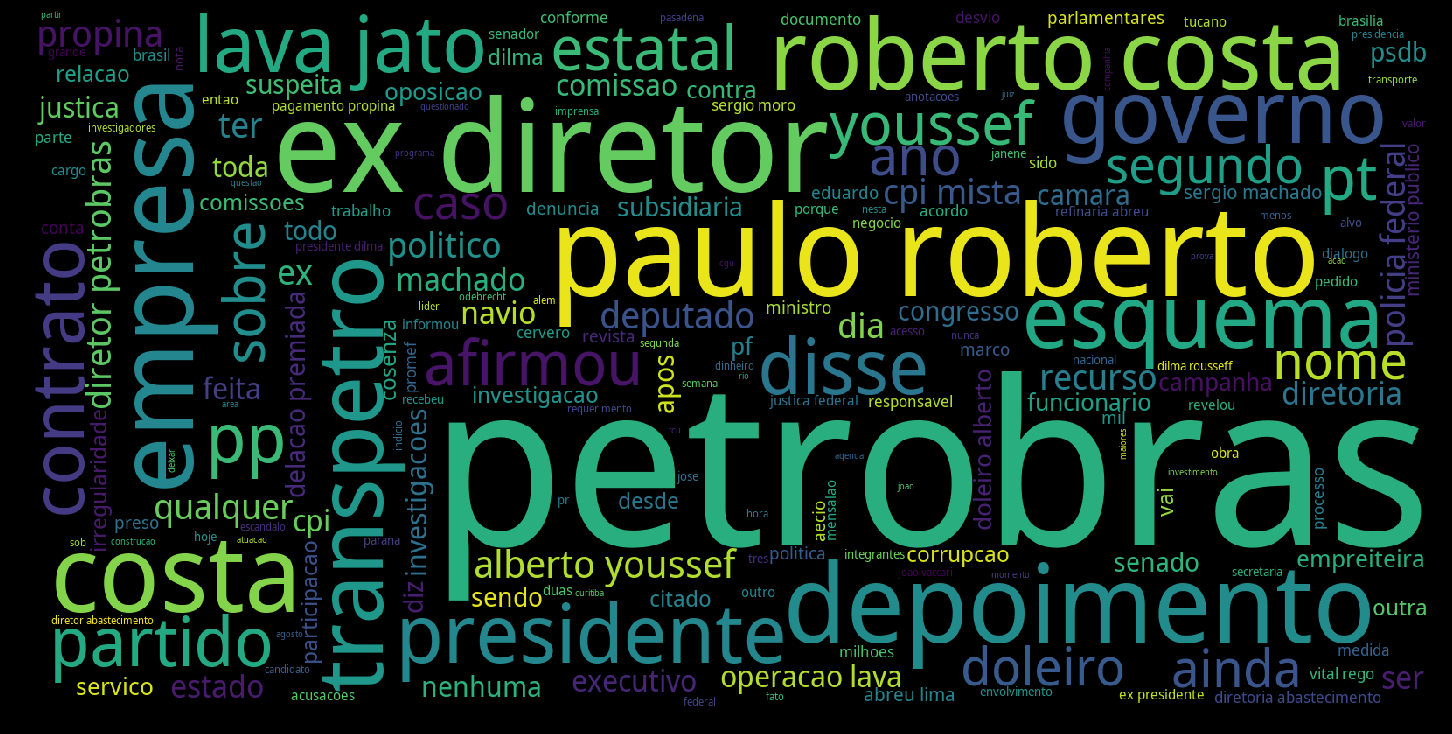

In [66]:
clusters = {}
terms_frequency = {}

for i in range(len(noticias)):
    clusters.setdefault(labels[i], []).append(noticias[i])

for group in sorted(clusters.keys()):
    clusters[group] = ' '.join(clusters[group])
    words = [word.lower() for word in nltk.word_tokenize(clusters[group])]
    word_frequency = Counter(words)
    terms_frequency[group] = word_frequency.most_common()
    print("\nCluster %d:" % (group+1))
    
    generate_wordcloud(clusters[group])
    
print("\n")

# Análise da nuvem de palavras de cada cluster

No cluster 1 podemos ver notícias que falam de campanhas eleitorais para presidente, bem como partidos políticos.

No cluster 2 vemos notícias relacionadas ao governo, incluindo o partido PT e PMDB, e ainda algumas citando campanhas.

No cluster 3, vemos notícias relacionadas à ex presidente Dilma Rousseff, entre outras.

No cluster 4, vemos mais notícias relacionadas à campanhas políticas, dessa vez focando em Marina e Aécio, e algumas relacionadas à Dilma também.

No cluster 5 vemos o foco nos partidos políticos.

No cluster 6 vemos notícias relacionadas à Petrobrás, empresas, lava jato, depoimentos, etc. 

## Top 10 palavras mais frequentes de cada cluster
Aqui é demonstrado, através de um grafico de barras, as top 10 palavras mais frequente em cada cluster

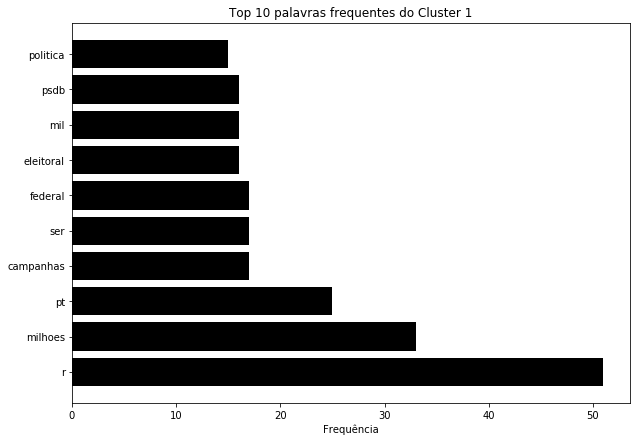

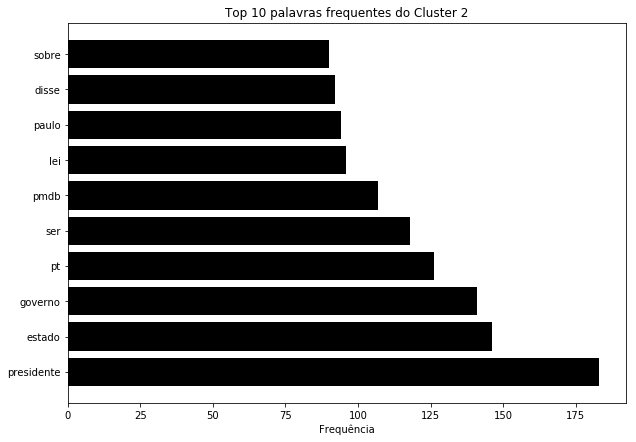

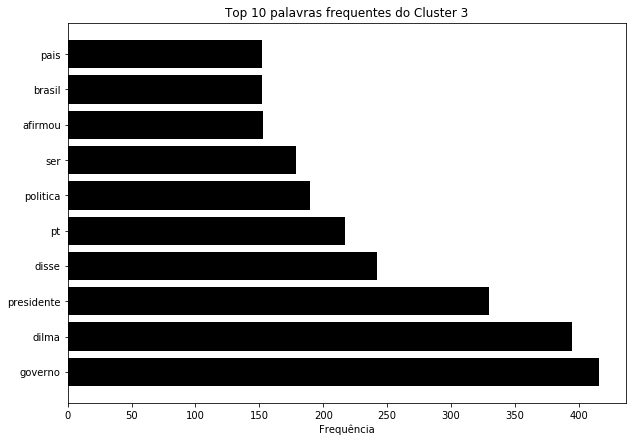

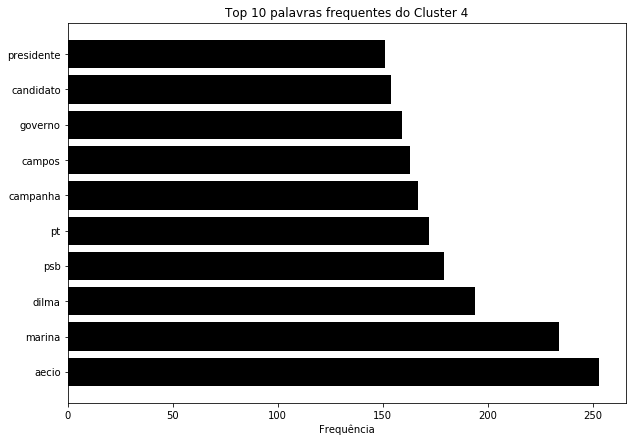

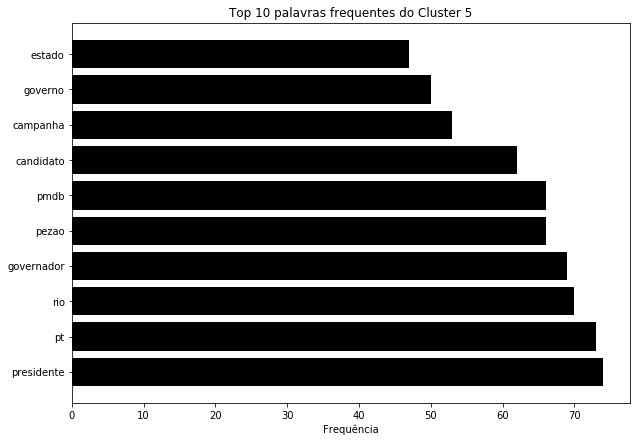

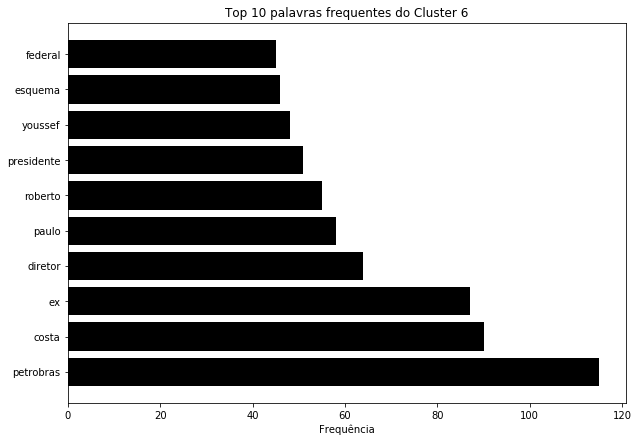

In [67]:
top_word_frequency(terms_frequency, 10)

In [68]:
tsne_init = 'pca'
tsne_perplexity = 20.0
tsne_early_exaggeration = 4.0
tsne_learning_rate = 1000
random_state = 1

model_centroids = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

model_points = TSNE(n_components=2, random_state=random_state, init=tsne_init, perplexity=tsne_perplexity,
         early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)

transformed_centroids = model_centroids.fit_transform(centroids)
point = model_points.fit_transform(X.toarray())

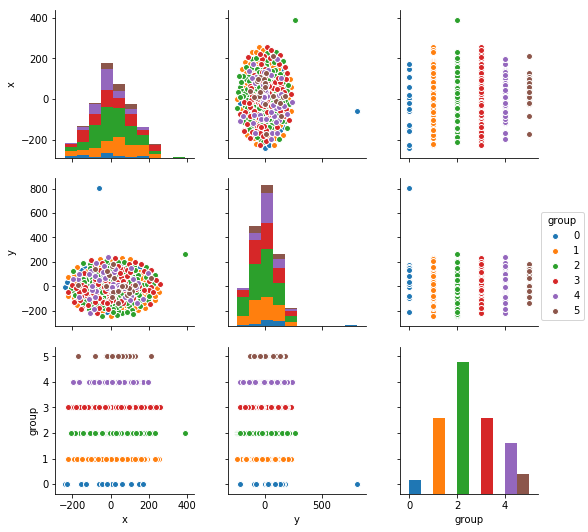

<Figure size 720x504 with 0 Axes>

In [69]:
df = pd.DataFrame(point, index = [i for i in range(len(point))], columns = ['x','y'])
df['group'] = labels
sb.pairplot(df, 'group')
plt.figure(figsize=(10,7))
plt.show()